In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import os
from census import Census
from pathlib import Path 

In [2]:
data=pd.read_csv('./data.csv')
data['ID_DATE'] = pd.to_datetime(data['ID_DATE']) #INITIAL DRAFT DATE
data['AD_DATE'] = pd.to_datetime(data['AD_DATE'])  #LATEST ADOPTION DATE

In [3]:
# Some duplicative jurisdictions have this adu or public lands email address that doesnt name anyone working at HCD
data.JURISDICTION.value_counts()

JURISDICTION
ALAMEDA                 1
INDIO                   1
LA PUENTE               1
LA PALMA                1
LA MESA                 1
                       ..
SANTA MARIA             1
SANTA BARBARA COUNTY    1
SANTA BARBARA           1
LOMPOC                  1
YUCCA VALLEY            1
Name: count, Length: 445, dtype: int64

In [4]:
data = data[~data.EMAIL.str.lower().str.contains('adu') & ~data.EMAIL.str.lower().str.contains('publiclands')]

In [5]:
data.JURISDICTION.value_counts().max()

1

In [6]:
data = data[data.ID_DATE.dt.year < 2024] # strictly speaking this should filter by COG. Dont worry about this Anne

In [7]:
data['EMAIL'] = data['EMAIL'].str.lower()


In [8]:
data.EMAIL.nunique()

44

In [9]:
data = data.replace(
    {'claire.sullivan@hcd.ca.gov': 'claire.sullivan-halpern@hcd.ca.gov',
     'halpern@hcd.ca.gov': 'claire.sullivan-halpern@hcd.ca.gov'}
)

In [10]:
data['NAME'] = data.EMAIL.str.split('@').str[0].str.split('.').str.join(' ').str.title()

In [11]:
k = 8 # this is semi-arbitrary
emails_with_enough_data = data.EMAIL.value_counts().index[data.EMAIL.value_counts() >= k]
emails_with_enough_data

Index(['jose.ayala@hcd.ca.gov', 'irvin.saldana@hcd.ca.gov',
       'shawn.danino@hcd.ca.gov', 'hillary.prasad@hcd.ca.gov',
       'chelsea.lee@hcd.ca.gov', 'sohab.mehmood@hcd.ca.gov',
       'colin.cross@hcd.ca.gov', 'reid.miller@hcd.ca.gov',
       'mashal.ayobi@hcd.ca.gov', 'jamillah.williams@hcd.ca.gov',
       'fidel.herrera@hcd.ca.gov', 'molivann.phlong@hcd.ca.gov',
       'tristan.lanza@hcd.ca.gov', 'gerlinde.bernd@hcd.ca.gov',
       'gianna.marasovich@hcd.ca.gov', 'paul.mcdougall@hcd.ca.gov',
       'marisa.prasse@hcd.ca.gov', 'dulce.ochoa@hcd.ca.gov',
       'anthony.errichetto@hcd.ca.gov', 'connor.finney@hcd.ca.gov',
       'jose.jauregui@hcd.ca.gov', 'divya.sen@hcd.ca.gov',
       'claire.sullivan-halpern@hcd.ca.gov'],
      dtype='object', name='EMAIL')

In [12]:
# Calculate the number of days between ID_DATE and AD_DATE
data['DAYS_BETWEEN'] = (data['AD_DATE'] - data['ID_DATE']).dt.days

# If DAYS BETWEEN is negative, insert the difference between today's date and the initial draft date
data['DAYS_BETWEEN2'] = (pd.to_datetime(datetime.today().date()) -  data['ID_DATE']).dt.days
data.loc[data.DAYS_BETWEEN >= 0, 'DAYS_BETWEEN2'] = data.DAYS_BETWEEN[data.DAYS_BETWEEN >= 0]

In [13]:
data_resolved = data[data.EMAIL.isin(emails_with_enough_data)].copy()

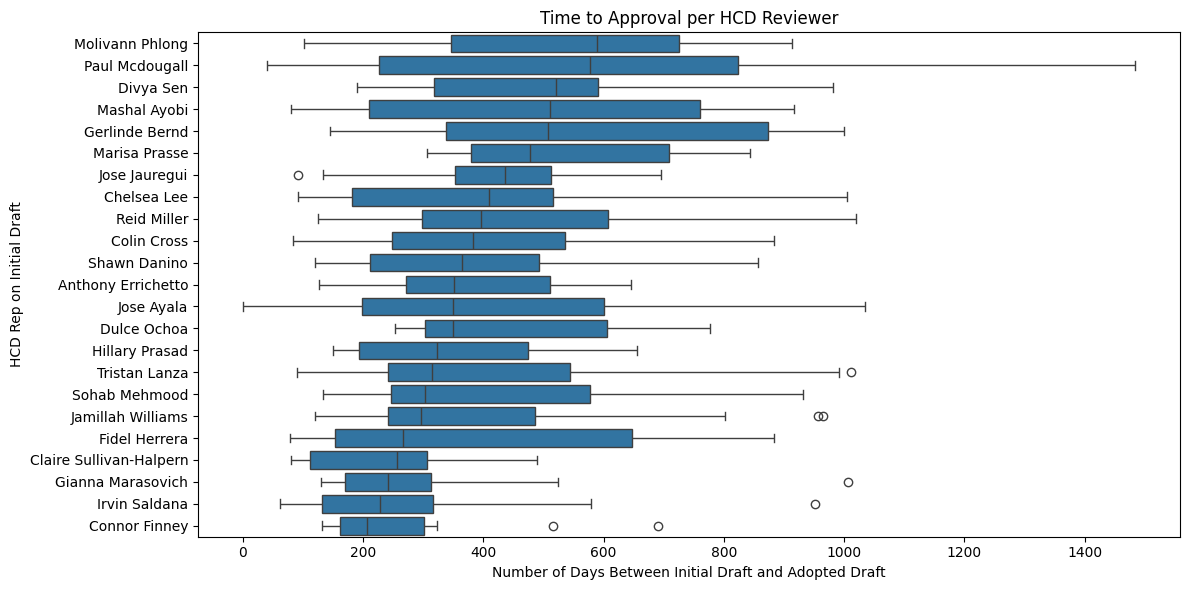

In [14]:
# Create a boxplot grouped by email
plt.figure(figsize=(12, 6))
sorted_data = data_resolved.groupby('NAME', observed=True)['DAYS_BETWEEN2'].median().sort_values(ascending=False).index
# Reorder the dataframe based on the sorted order
data_resolved['NAME'] = pd.Categorical(data_resolved['NAME'], categories=sorted_data, ordered=True)

sns.boxplot(data=data_resolved, y='NAME', x='DAYS_BETWEEN2',  order=sorted_data)
plt.title('Time to Approval per HCD Reviewer')
max_days = data_resolved['DAYS_BETWEEN2'].max()
min_days= data_resolved['DAYS_BETWEEN2'].min()

plt.ylabel('HCD Rep on Initial Draft')
plt.xlabel('Number of Days Between Initial Draft and Adopted Draft')
plt.tight_layout()
plt.show()


In [16]:
with open(Path.home() / 'api.census_api_key', 'r') as file:
    census_api_key = file.read().strip()

c = Census(census_api_key)


census_city_data = c.acs5.state_place(['NAME', 'B01003_001E', 'B23025_001E', 'B25077_001E', 'B19013_001E'],
                                      state_fips='06',
                                      place='*')

census_city_data = [c for c in census_city_data if 'CDP' not in c.get('NAME')]

census_city_df = pd.DataFrame(census_city_data)

variable_name_map = {
    'B01003_001E': 'pop_size_acs21',
    'B23025_001E': 'num_employed_acs21',
    'B25077_001E': 'home_price_acs21',
    'B19013_001E': 'median_income_acs21'
}

census_city_df = census_city_df.rename(columns=variable_name_map)

census_city_df.NAME = census_city_df.NAME.str.split(' ').str[:-2].str.join(' ')

In [19]:
census_city_df['JURISDICTION']=census_city_df['NAME'].str.upper()
census_city_df.JURISDICTION.unique()

array(['ADELANTO', 'AGOURA HILLS', 'ALAMEDA', 'ALBANY', 'ALHAMBRA',
       'ALISO VIEJO', 'ALTURAS', 'AMADOR CITY', 'AMERICAN CANYON',
       'ANAHEIM', 'ANDERSON', 'ANGELS', 'ANTIOCH', 'APPLE VALLEY',
       'ARCADIA', 'ARCATA', 'ARROYO GRANDE', 'ARTESIA', 'ARVIN',
       'ATASCADERO', 'ATHERTON', 'ATWATER', 'AUBURN', 'AVALON', 'AVENAL',
       'AZUSA', 'BAKERSFIELD', 'BALDWIN PARK', 'BANNING', 'BARSTOW',
       'BEAUMONT', 'BELL', 'BELLFLOWER', 'BELL GARDENS', 'BELMONT',
       'BELVEDERE', 'BENICIA', 'BERKELEY', 'BEVERLY HILLS',
       'BIG BEAR LAKE', 'BIGGS', 'BISHOP', 'BLUE LAKE', 'BLYTHE',
       'BRADBURY', 'BRAWLEY', 'BREA', 'BRENTWOOD', 'BRISBANE', 'BUELLTON',
       'BUENA PARK', 'BURBANK', 'BURLINGAME', 'CALABASAS', 'CALEXICO',
       'CALIFORNIA CITY', 'CALIMESA', 'CALIPATRIA', 'CALISTOGA',
       'CAMARILLO', 'CAMPBELL', 'CANYON LAKE', 'CAPITOLA', 'CARLSBAD',
       'CARMEL-BY-THE-SEA', 'CARPINTERIA', 'CARSON', 'CATHEDRAL CITY',
       'CERES', 'CERRITOS', 'CHICO', 'CHINO

In [21]:
data2 = pd.read_csv('./6th-cycle-rhna-progress.csv',)
data2.JURISDICTION = data2.JURISDICTION.str.upper()
data2

,JURISDICTION,PLANNING PERIOD,6TH CYCLE STARTED,VLI UNITS,RHNA VLI,VLI %,LI UNITS,RHNA LI,LI %,MOD UNITS,RHNA MOD,MOD %,ABOVE MOD UNITS,RHNA ABOVE MOD,ABOVE MOD %
0,ADELANTO,10/15/2021 - 10/15/2029,True,NaN,394,NaN,NaN,566,NaN,NaN,651,NaN,106.0,2152,4.9%
1,AGOURA HILLS,10/15/2021 - 10/15/2029,True,5.0,127,3.9%,16.0,72,22.2%,3.0,55,5.5%,11.0,64,17.2%
2,ALAMEDA,1/31/2023 - 1/31/2031,True,13.0,1421,0.9%,11.0,818,1.3%,19.0,868,2.2%,92.0,2246,4.1%
3,ALAMEDA COUNTY,1/31/2023 - 1/31/2031,True,103.0,1251,8.2%,112.0,721,15.5%,33.0,763,4.3%,72.0,1976,3.6%
4,ALBANY,1/31/2023 - 1/31/2031,True,NaN,308,NaN,NaN,178,NaN,10.0,175,5.7%,NaN,453,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,YREKA,2/15/2023 - 2/15/2031,True,NaN,1,NaN,NaN,1,NaN,NaN,0,NaN,NaN,0,NaN
535,YUBA CITY,5/15/2021 - 5/15/2029,True,NaN,756,NaN,NaN,455,NaN,NaN,622,NaN,131.0,1475,8.9%
536,YUBA COUNTY,5/15/2021 - 5/15/2029,True,1.0,621,0.2%,90.0,374,24.1%,5.0,561,0.9%,1335.0,1331,100.3%
537,YUCAIPA,10/15/2021 - 10/15/2029,True,NaN,708,NaN,138.0,493,28.0%,86.0,511,16.8%,364.0,1154,31.5%


In [22]:
combined = data.merge(data2, on='JURISDICTION',how='left', indicator=True)

In [23]:
#cities that do not match any jurisdiction 
combined[combined._merge == 'left_only']

,Unnamed: 0,JURISDICTION,EMAIL,ID_DATE,AD_DATE,COUNTY,pageCount,checkP1,checkP2,checkP3,...,LI UNITS,RHNA LI,LI %,MOD UNITS,RHNA MOD,MOD %,ABOVE MOD UNITS,RHNA ABOVE MOD,ABOVE MOD %,_merge
15,16,AMADOR CITY,jose.ayala@hcd.ca.gov,2023-05-08,2023-05-08,AMADOR,16,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
341,373,RANCHO ST. MARGARITA,tristan.lanza@hcd.ca.gov,2021-12-21,2013-10-17,ORANGE,11,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
355,387,SAN BUENAVENTURA,shawn.danino@hcd.ca.gov,2021-10-11,2023-10-09,VENTURA,12,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [24]:
#Change the jurisdiction to  AMADOR COUNTY
data.loc[data['JURISDICTION']=='AMADOR CITY', 'JURISDICTION']='AMADOR COUNTY'
data.loc[data['JURISDICTION']=='RANCHO ST. MARGARITA', 'JURISDICTION']='ORANGE COUNTY'
data.loc[data['JURISDICTION']=='SAN BUENAVENTURA', 'JURISDICTION']='VENTURA COUNTY'not_matched=list(set(census_city_df.JURISDICTION) - set(combined.JURISDICTION))
for juris in not_matched:
    new_juris = combined[combined.JURISDICTION.str.contains(juris)].JURISDICTION.values
    if new_juris:
        print(juris,new_juris)

In [25]:
#Update combined df
combined =  data.merge(data2, on='JURISDICTION',how='left', indicator=True)
combined[combined._merge == 'left_only']

,Unnamed: 0,JURISDICTION,EMAIL,ID_DATE,AD_DATE,COUNTY,pageCount,checkP1,checkP2,checkP3,...,LI UNITS,RHNA LI,LI %,MOD UNITS,RHNA MOD,MOD %,ABOVE MOD UNITS,RHNA ABOVE MOD,ABOVE MOD %,_merge


In [26]:
combined = combined.drop(columns=['_merge'])
combined.to_csv('./data_updated.csv')

In [27]:
combined

,Unnamed: 0,JURISDICTION,EMAIL,ID_DATE,AD_DATE,COUNTY,pageCount,checkP1,checkP2,checkP3,...,VLI %,LI UNITS,RHNA LI,LI %,MOD UNITS,RHNA MOD,MOD %,ABOVE MOD UNITS,RHNA ABOVE MOD,ABOVE MOD %
0,0,ALAMEDA,claire.sullivan-halpern@hcd.ca.gov,2022-08-25,2022-12-20,ALAMEDA,2,False,False,False,...,0.9%,11.0,818,1.3%,19.0,868,2.2%,92.0,2246,4.1%
1,2,ALBANY,claire.sullivan-halpern@hcd.ca.gov,2022-12-09,2023-09-08,ALAMEDA,8,True,False,False,...,NaN,NaN,178,NaN,10.0,175,5.7%,NaN,453,NaN
2,3,BERKELEY,jose.ayala@hcd.ca.gov,2022-11-08,2023-02-28,ALAMEDA,6,True,False,False,...,2.5%,49.0,1408,3.5%,25.0,1416,1.8%,285.0,3664,7.8%
3,4,DUBLIN,jose.ayala@hcd.ca.gov,2022-08-29,2024-01-19,ALAMEDA,12,True,False,False,...,NaN,NaN,625,NaN,NaN,560,NaN,370.0,1449,25.5%
4,5,EMERYVILLE,claire.sullivan-halpern@hcd.ca.gov,2022-10-31,2023-02-03,ALAMEDA,2,False,False,False,...,11.8%,36.0,259,13.9%,NaN,308,NaN,26.0,797,3.3%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,440,WOODLAND,hillary.prasad@hcd.ca.gov,2021-07-12,2023-04-28,YOLO,13,True,False,False,...,17.0%,44.0,399,11.0%,95.0,601,15.8%,234.0,1424,16.4%
409,441,YORBA LINDA,colin.cross@hcd.ca.gov,2021-10-26,2022-04-08,ORANGE,12,True,False,False,...,5.0%,13.0,451,2.9%,9.0,457,2.0%,34.0,742,4.6%
410,442,YUBA CITY,irvin.saldana@hcd.ca.gov,2021-08-12,2022-05-05,SUTTER,4,True,False,False,...,NaN,NaN,455,NaN,NaN,622,NaN,131.0,1475,8.9%
411,443,YUCAIPA,divya.sen@hcd.ca.gov,2021-11-01,2022-10-21,SAN BERNARDINO,13,True,False,False,...,NaN,138.0,493,28.0%,86.0,511,16.8%,364.0,1154,31.5%


In [28]:
np.mean((data['checkP1'].astype(int) + data['checkP2'].astype(int) + 
         data['checkP3'].astype(int) + data['checkP4'].astype(int)) == 0)

0.002421307506053269

In [29]:
data[~(data['checkP1'] | data['checkP2'] | data['checkP3'] | data['checkP4'])]

,Unnamed: 0,JURISDICTION,EMAIL,ID_DATE,AD_DATE,COUNTY,pageCount,checkP1,checkP2,checkP3,checkP4,NAME,DAYS_BETWEEN,DAYS_BETWEEN2
323,323,LOOMIS,irvin.saldana@hcd.ca.gov,2021-07-12,2021-11-19,PLACER,5,False,False,False,False,Irvin Saldana,130,130


In [30]:
data_resolved['init_draft_score'] = 0
data_resolved['init_draft_score'] += 1.0 * data_resolved['checkP1']
data_resolved['init_draft_score'] += 2.0 * data_resolved['checkP2']
data_resolved['init_draft_score'] += 3.0 * data_resolved['checkP3']
data_resolved['init_draft_score'] += 4.0 * data_resolved['checkP4']

<Axes: xlabel='pageCount_jittered', ylabel='init_draft_score_jittered'>

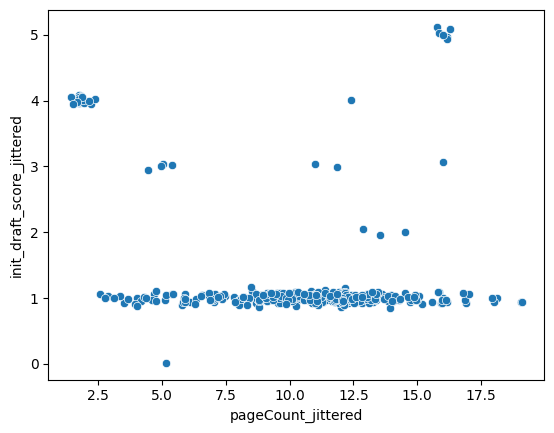

In [31]:
to_plot = data_resolved.copy()
to_plot['pageCount_jittered'] = to_plot['pageCount'] + np.random.normal(0, 0.25, size=len(to_plot))
to_plot['init_draft_score_jittered'] = to_plot['init_draft_score'] + np.random.normal(0, 0.05, size=len(to_plot))

sns.scatterplot(x='pageCount_jittered', y='init_draft_score_jittered', data=to_plot)

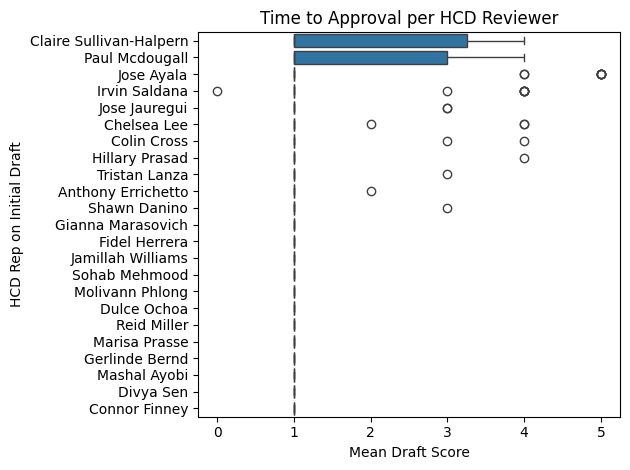

In [32]:
to_plot = data_resolved.copy()
sorted_data = to_plot.groupby('NAME', observed=True)['init_draft_score'].mean().sort_values(ascending=False).index

data_resolved['NAME'] = pd.Categorical(to_plot['NAME'], categories=sorted_data, ordered=True)

sns.boxplot(data=data_resolved, y='NAME', x='init_draft_score',  order=sorted_data)
plt.title('Time to Approval per HCD Reviewer')
max_days = to_plot['init_draft_score'].max()
min_days= to_plot['init_draft_score'].min()

plt.ylabel('HCD Rep on Initial Draft')
plt.xlabel('Mean Draft Score')
plt.tight_layout()
plt.show()

In [35]:
#Check similar names for city and jurisdiction
not_matched=list(set(census_city_df.JURISDICTION) - set(combined.JURISDICTION))
for juris in not_matched:
    new_juris = combined[combined.JURISDICTION.str.contains(juris)].JURISDICTION.values
    if new_juris:
        print(juris,new_juris)

MADERA ['CORTE MADERA']
TULARE ['TULARE COUNTY']
PORTOLA ['PORTOLA VALLEY']


/var/folders/5q/4yrrbz293953sqpsf82n6d3r0000gn/T/ipykernel_1810/4152656267.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if new_juris:
/var/folders/5q/4yrrbz293953sqpsf82n6d3r0000gn/T/ipykernel_1810/4152656267.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  new_juris = combined[combined.JURISDICTION.str.contains(juris)].JURISDICTION.values


In [36]:
census_city_df.loc[census_city_df.JURISDICTION=='TULARE','JURISDICTION'] = 'TULARE COUNTY'
census_city_df.loc[census_city_df.JURISDICTION=='PORTOLA','JURISDICTION'] = 'PLUMAS'
census_city_df.loc[census_city_df.JURISDICTION=='MADERA','JURISDICTION'] = 'LOS ANGELES'


In [37]:
not_matched=list(set(census_city_df.JURISDICTION) - set(combined.JURISDICTION))
#Based on chatgpt
not_matched_dict = {'LOS ANGELES':[
    "AGOURA HILLS",
    "ALHAMBRA",
    "ALISO VIEJO",
    "ARTESIA",
    "AVALON",
    "AZUSA",
    "BALDWIN PARK",
    "BELL",
    "BELLFLOWER",
    "BELL GARDENS",
    "BEVERLY HILLS",
    "CARSON",
    "CERRITOS",
    "COMPTON",
    "COVINA",
    "CULVER CITY",
    "DOWNEY",
    "DUARTE",
    "EL MONTE",
    "HAWTHORNE",
    "HUNTINGTON PARK",
    "INGLEWOOD",
    "LA HABRA HEIGHTS",
    "LAKEWOOD",
    "LANCASTER",
    "LAWNDALE",
    "LONG BEACH",
    "LOS ANGELES",
    "MALIBU",
    "MAYWOOD",
    "MONTEBELLO",
    "MONTEREY PARK",
    "PARAMOUNT",
    "PICO RIVERA",
    "REDONDO BEACH",
    "SANTA MONICA",
    "SOUTH GATE",
    "TORRANCE",
    "WALNUT",
    "WEST HOLLYWOOD",
    "WHITTIER"
],'ORANGE COUNTY':[
    "ALISO VIEJO",
    "ANAHEIM",
    "BREA",
    "BUENA PARK",
    "COSTA MESA",
    "CYPRESS",
    "DANA POINT",
    "FULLERTON",
    "GARDEN GROVE",
    "HUNTINGTON BEACH",
    "IRVINE",
    "LA HABRA",
    "LAKE FOREST",
    "LAGUNA BEACH",
    "LAGUNA HILLS",
    "LAGUNA NIGUEL",
    "LAGUNA WOODS",
    "MISSION VIEJO",
    "NEWPORT BEACH",
    "ORANGE",
    "PLACENTIA",
    "RANCHO SANTA MARGARITA",
    "SAN CLEMENTE",
    "SAN JUAN CAPISTRANO",
    "SANTA ANA",
    "SANTA MARGARITA",
    "TUSTIN",
    "VILLA PARK",
    "WESTMINSTER",
    "YORBA LINDA"
],'RIVERSIDE COUNTY':[
    "BANNING",
    "BEAUMONT",
    "CALIMESA",
    "CANYON LAKE",
    "CATALINA ISLAND",
    "COACHELLA",
    "CORONA",
    "DESERT HOT SPRINGS",
    "HEMET",
    "LAKE ELSINORE",
    "MURRIETA",
    "NORCO",
    "PERRIS",
    "RANCHO MIRAGE",
    "RIVERSIDE",
    "SAN JACINTO",
    "TEMECULA",
    "WILDOMAR"
],"SAN BERNARDINO":[
    "BARSTOW",
    "BLOOMINGTON",
    "COLTON",
    "CRESTLINE",
    "FONTANA",
    "HIGHLAND",
    "LAKE ARROWHEAD",
    "LOMA LINDA",
    "MONTCLAIR",
    "ONTARIO",
    "RANCHO CUCAMONGA",
    "REDLANDS",
    "RIALTO",
    "SAN BERNARDINO",
    "UPLAND",
    "VICTORVILLE",
    "WRIGHTWOOD"
],'SAN DIEGO':[
    "CARLSBAD",
    "CHULA VISTA",
    "EL CAJON",
    "ENCINITAS",
    "ESCONDIDO",
    "GREAT MEADOWS",
    "LA MESA",
    "OCEANSIDE",
    "POWAY",
    "SAN DIEGO",
    "SAN MARCOS",
    "SANTEE",
    "SOLANA BEACH",
    "VISTA"
],'FRESNO COUNTY':['FRESNO'],'IMPERIAL COUNTY':['EL CENTRO','IMPERIAL'],
    "KERN COUNTY":['BAKERSFIELD', 'TEHACHAPI'],
    'SANTA BARBARA COUNTY':['LOMPOC', 'SANTA BARBARA'],
                    'VENTURA':['OXNARD', 'VENTURA'],
                    'SAN LUIS OBISPO COUNTY':['SAN LUIS OBISPO'],
                   'SACRAMENTO COUNTY':['ELK GROVE','FOLSOM','SACRAMENTO','WEST SACRAMENTO'],
                   'CONTRA COSTA COUNTY':['BRENTWOOD','CLAYTON','CONCORD','PITTSBURG','RICHMOND']}
                    


In [38]:
#UPDATE JURISDICTION of census_city_df
for key,values in not_matched_dict.items():
    for val in values:
        census_city_df.loc[census_city_df.JURISDICTION==val,'JURISDICTION'] = key

        

In [39]:
new_df=combined.merge(census_city_df,on=['JURISDICTION'],how='left', indicator=True)

In [40]:
#unmatched combined.JURISDICTION 
new_df[new_df._merge=='left only'].JURISDICTION.unique()

array([], dtype=object)